## Importing neccessary libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset preview

In [2]:

with open('/Users/user/Downloads/customer_orders.pkl', 'rb') as file:
    customer_orders = pickle.load(file)

print("-" * 50)
print("TYPE OF customer_orders")
print("-" * 50)
print(type(customer_orders))

print("\n" + "-" * 50)
print("CONTENTS OF customer_orders")
print("-" * 50)
print(customer_orders)

--------------------------------------------------
TYPE OF customer_orders
--------------------------------------------------
<class 'list'>

--------------------------------------------------
CONTENTS OF customer_orders
--------------------------------------------------
[{'id': 1, 'name': 'Customer 1', 'registration_date': '2022-12-31 04:19:19', 'orders': [{'order_id': 84, 'order_date': '2024-02-27 21:24:16', 'shipping_address': '840 Main St, City 8', 'order_total_value': 0, 'items': []}, {'order_id': None, 'order_date': '2025-05-03 08:09:20', 'shipping_address': '533 Main St, City 9', 'order_total_value': 2765.8, 'items': [{'item_id': 1, 'product_name': 'Item 1 for Order 2', 'category': 4, 'price': 52.7, 'quantity': 2}, {'item_id': 2, 'product_name': 'Item 2 for Order 2', 'category': 5, 'price': 498.45, 'quantity': 5}, {'item_id': 3, 'product_name': 'Item 3 for Order 2', 'category': 5, 'price': 168.15, 'quantity': 1}]}, {'order_id': 3, 'order_date': '2023-09-06 00:42:50', 'shipping_a

## Data Extraction Class

In [3]:
import pandas as pd
import pickle
import numpy as np

class CustomerDataExtractor:

    def __init__(self, orders, vip):
        self.orders = orders
        self.vip = vip
        self.vip_idx = set()
        self.data = []
        self.transformed = []

    Categories = {
        1: 'Electronics',
        2: 'Apparel',
        3: 'Books',
        4: 'Home Goods'
    }

    def load_vip_customers(self):
        with open(self.vip, 'r') as f:
            self.vip_idx = set(int(line.strip()) for line in f if line.strip().isdigit())

    def load_customer_orders(self):
        with open(self.orders, 'rb') as f:
            self.data = pickle.load(f)

    def clean_price(self, price):
        if price is None:
            return np.nan
        if isinstance(price, str):
            price = price.strip()
            if price.lower() == 'invalid':
                return np.nan
            if price.startswith('$'):
                price = price[1:]
            try:
                return float(price)
            except ValueError:
                return np.nan
        try:
            return float(price)
        except:
            return np.nan

    def clean_quantity(self, qty):
        if qty is None:
            return np.nan
        if isinstance(qty, str):
            qty = qty.strip().lower()
            if qty == 'free':
                return 0
            try:
                return int(qty)
            except ValueError:
                return np.nan
        try:
            return int(qty)
        except:
            return np.nan
    
    def resolve_category(self, category):
        if isinstance(category, str):
            cat_norm = category.strip().lower()
            for name in self.Categories.values():
                if cat_norm == name.lower():
                    return name
        elif isinstance(category, int):  
            return self.Categories.get(category, 'Misc')
        return 'Misc'
        
    def clean_order_id(self, order_id):
        if order_id is None:
            return -1
        try:
            return int(order_id)
        except (ValueError, TypeError):
            digits = ''.join(filter(str.isdigit, str(order_id)))
            if digits:
                return int(digits)
            else:
                return -1


    def transform(self):
        for customer in self.data:
            customer_id = int(customer.get('id', -1))
            customer_name = customer.get('name', '')
            reg_date = pd.to_datetime(customer.get('registration_date'), errors='coerce')
            is_vip = customer_id in self.vip_idx

            for order in customer.get('orders', []):
                order_id = self.clean_order_id(order.get('order_id'))
                order_date = pd.to_datetime(order.get('order_date'), errors='coerce')
                items = order.get('items', [])

                total_order_value = order.get('order_total_value')
                if not total_order_value or total_order_value <= 0:
                    total_order_value = sum(
                        self.clean_price(item.get('price')) * self.clean_quantity(item.get('quantity'))
                        for item in items
                    ) or 1.0

                for item in items:
                    unit_price = self.clean_price(item.get('price'))
                    quantity = self.clean_quantity(item.get('quantity'))
                    total_item_price = unit_price * quantity
                    percentage = total_item_price / total_order_value

                    self.transformed.append({
                        'customer_id': customer_id,
                        'customer_name': customer_name,
                        'registration_date': reg_date,
                        'is_vip': is_vip,
                        'order_id': order_id,
                        'order_date': order_date,
                        'product_id': self.clean_order_id(item.get('item_id')),
                        'product_name': item.get('product_name', ''),
                        'category': self.resolve_category(item.get('category')),
                        'unit_price': unit_price,
                        'item_quantity': quantity,
                        'total_item_price': total_item_price,
                        'total_order_value_percentage': percentage
                    })

    def get_dataframe(self):
        df = pd.DataFrame(self.transformed)
        return df.sort_values(['customer_id', 'order_id', 'product_id'], ascending=True).reset_index(drop=True)


    def run(self):
        self.load_vip_customers()
        self.load_customer_orders()
        self.transform()
        return self.get_dataframe()


## Testing and getting the cleaned datafarme

In [4]:
extractor = CustomerDataExtractor(
    orders='/Users/user/Downloads/customer_orders.pkl',
    vip='/Users/user/Downloads/vip_customers.txt'
)

data_cleaned = extractor.run()
print("TYPES OF cleaned data")
print("-" * 50)

print(data_cleaned.dtypes)
print("-" * 50)
print("Cleaned data preview")
print("-" * 50)

print(data_cleaned.head())
print("-" * 50)



TYPES OF cleaned data
--------------------------------------------------
customer_id                              int64
customer_name                           object
registration_date               datetime64[ns]
is_vip                                    bool
order_id                                 int64
order_date                      datetime64[ns]
product_id                               int64
product_name                            object
category                                object
unit_price                             float64
item_quantity                            int64
total_item_price                       float64
total_order_value_percentage           float64
dtype: object
--------------------------------------------------
Cleaned data preview
--------------------------------------------------
   customer_id customer_name   registration_date  is_vip  order_id  \
0            1    Customer 1 2022-12-31 04:19:19    True        -1   
1            1    Customer 1 2022-12-31

## Checking if all the final data types are correct )

In [5]:
def check_dtypes(df):
    expected_types = {
        'customer_id': 'int64',
        'customer_name': 'object',
        'registration_date': 'datetime64[ns]',
        'is_vip': 'bool',
        'order_id': 'int64',
        'order_date': 'datetime64[ns]',
        'product_id': 'int64',
        'product_name': 'object',
        'category': 'object',
        'unit_price': 'float64',
        'item_quantity': 'int64',
        'total_item_price': 'float64',
        'total_order_value_percentage': 'float64'
    }
    
    for col, expected_type in expected_types.items():
        actual_type = str(df[col].dtype)
        if actual_type != expected_type:
            print(f"Column '{col}' has type {actual_type} but expected {expected_type}")
        else:
            print(f"Column '{col}' type check passed ({actual_type})")


In [6]:
check_dtypes(data_cleaned)

Column 'customer_id' type check passed (int64)
Column 'customer_name' type check passed (object)
Column 'registration_date' type check passed (datetime64[ns])
Column 'is_vip' type check passed (bool)
Column 'order_id' type check passed (int64)
Column 'order_date' type check passed (datetime64[ns])
Column 'product_id' type check passed (int64)
Column 'product_name' type check passed (object)
Column 'category' type check passed (object)
Column 'unit_price' type check passed (float64)
Column 'item_quantity' type check passed (int64)
Column 'total_item_price' type check passed (float64)
Column 'total_order_value_percentage' type check passed (float64)


In [7]:
data_cleaned.to_csv('cleaned_customer_orders.csv', index=False)


## Statistics from the dataset

In [8]:

data_cleaned['order_date'] = pd.to_datetime(data_cleaned['order_date'])

total_orders = data_cleaned['order_id'].nunique()
total_customers = data_cleaned['customer_id'].nunique()
total_revenue = data_cleaned['total_item_price'].sum()

top_products = data_cleaned.groupby('product_name')['total_item_price'].sum().sort_values(ascending=False).head(10)
category_revenue = data_cleaned.groupby('category')['total_item_price'].sum().sort_values(ascending=False)
avg_items_per_order = data_cleaned.groupby('order_id')['item_quantity'].sum().mean()

monthly_revenue = (
    data_cleaned
    .set_index('order_date')
    .resample('M')['total_item_price']
    .sum()
)




/var/folders/5z/jxsqfzd56z75p0hz3j1vd5v40000gn/T/ipykernel_31575/4187261220.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


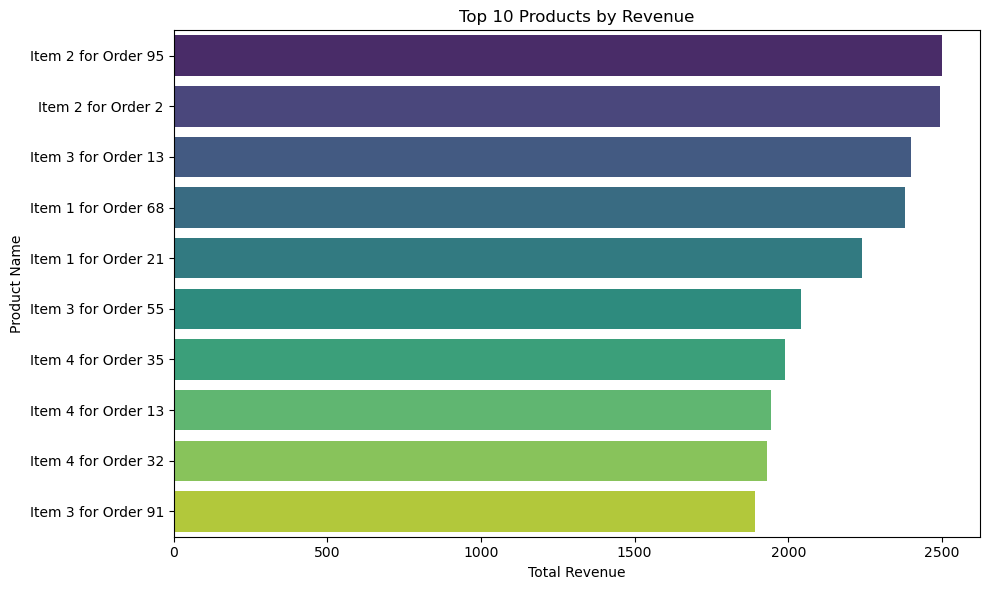

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Name')
plt.tight_layout()
plt.show()

/var/folders/5z/jxsqfzd56z75p0hz3j1vd5v40000gn/T/ipykernel_31575/3468195328.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_revenue.values, y=category_revenue.index, palette='magma')


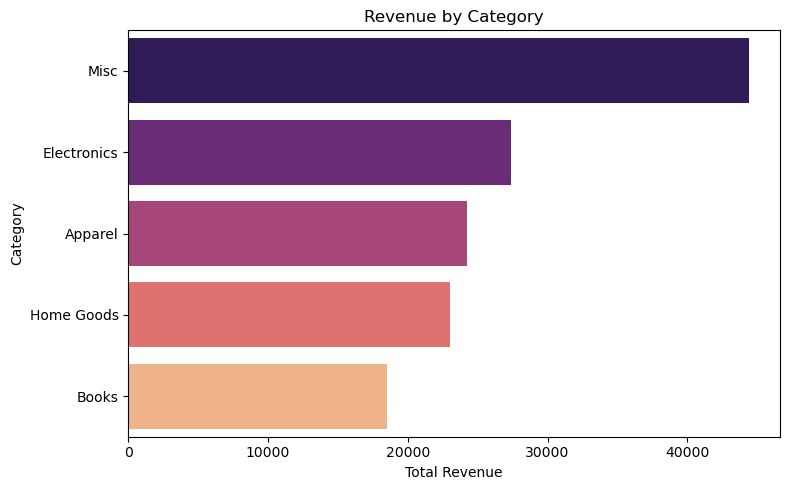

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(x=category_revenue.values, y=category_revenue.index, palette='magma')
plt.title('Revenue by Category')
plt.xlabel('Total Revenue')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


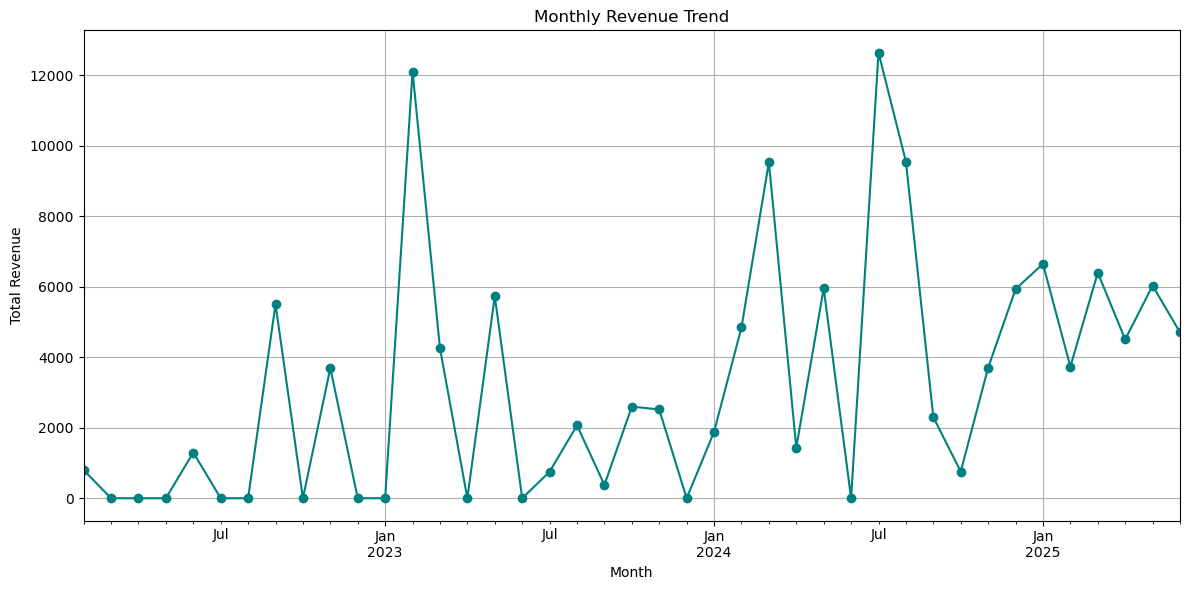

In [11]:
monthly_revenue = (
    data_cleaned
    .set_index('order_date')
    .resample('M')['total_item_price']
    .sum()
)

plt.figure(figsize=(12, 6))
monthly_revenue.plot(marker='o', color='teal')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()
